## CSS Project Part 2
Arathy Pillai, Alexander Guth, Hammad Akthar, Hiba Saleel and Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.plotting import scatter_matrix
from string import punctuation
from scipy import stats
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, mean_absolute_error
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns

In [2]:
plot_size = plt.rcParams["figure.figsize"]  
plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

### Load data and determine na values
repost and Text are determined as na values, because they ... **[TODO]**

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0', '', 'Text', 'repost', 'r e p o s t -', 'Repost']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)
#ira_data = ira_data[(ira_data['AD_IMPRESSIONS']> 0) & ira_data['AD_CLICKS'] > 0]

### Click per View Ratio
#Clicks / #Impressions

In [4]:
ira_data.insert(5, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

### Date operations
Get epoch time (ms since 01.01.1970)

In [5]:
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

def time_to_ms(dt):
    return dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1000 / 1000

In [6]:
ira_data['AD_CREATION_WEEKDAY'] = ira_data['AD_CREATION_DATE'].dt.dayofweek
ira_data['AD_CREATION_YEAR'] = ira_data['AD_CREATION_DATE'].dt.year
ira_data['AD_CREATION_MONTH'] = ira_data['AD_CREATION_DATE'].dt.month
ira_data['AD_CREATION_DAY'] = ira_data['AD_CREATION_DATE'].dt.day
ira_data['AD_CREATION_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: time_to_ms(x))
ira_data['AD_CREATION_EPOCH_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: unix_time_millis(x))

### Convert ruble
Removes "RUB" from the cell AD_SPEND

In [7]:
ira_data['AD_SPEND']=ira_data['AD_SPEND'].str.replace(' RUB','').astype('float')

### Drop all subsets, where AD_TEXT is na

In [8]:
ira_data=ira_data.dropna(subset=['AD_TEXT']);
ira_data['AD_TEXT'].count()

3436

### Cleaning up Targeting Data

In [9]:
def remove_punctuation_at_the_end(x):
    #remove "," and "." and ":" from the end of x
    x = x.rstrip(',')
    x = x.rstrip('.')
    x = x.rstrip(':')
    #replace ";" and ",." with "," in x
    x = x.replace(';', ',')
    x = x.replace(',.', ',')
    return x

In [10]:
#replace abbreviations with their long form in AD_TARGETING_EXCLUDED_CONNECTIONS
ira_data['AD_TARGETING_EXCLUDED_CONNECTIONS']=ira_data['AD_TARGETING_EXCLUDED_CONNECTIONS'].str.replace('Exclude people who like BM','Exclude people who like Black Matters')

#replace ")or" (missing space) with ") or" and ");" with ")," in AD_TARGETING_LANGUAGE due to having a different formats used
ira_data['AD_TARGETING_LANGUAGE'] = ira_data['AD_TARGETING_LANGUAGE'].str.replace('\)or', ') or')
ira_data['AD_TARGETING_LANGUAGE'] = ira_data['AD_TARGETING_LANGUAGE'].str.replace('\);', '),')

#??Remove lines without AD_TARGETING_INTERESTS and execute remove_punctuation_at_the_end on each string in AD_TARGETING_INTERESTS
ira_data['AD_TARGETING_INTERESTS'] = ira_data['AD_TARGETING_INTERESTS'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))
ira_data['AD_TARGETING_PEOPLE_WHO_MATCH'] = ira_data['AD_TARGETING_PEOPLE_WHO_MATCH'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))
ira_data['AD_TARGETING_EXCLUDE'] = ira_data['AD_TARGETING_EXCLUDE'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))

### Remove hyperlinks

In [11]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'http?:\/\/.*[\r\n]*', '')

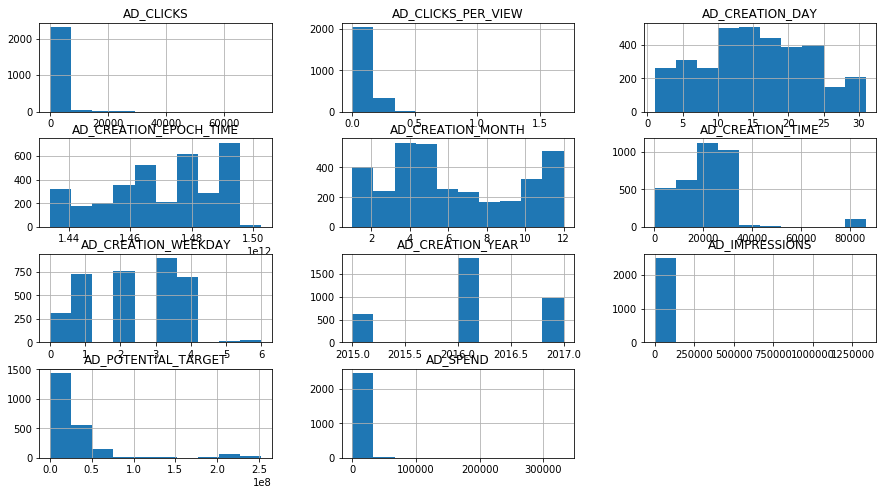

In [12]:
ira_data.hist();

### Common Statistics
**[TODO]** Mean, median etc. for success --> Chart(?) ==> Alex

### Correlations

In [13]:
colormap = plt.cm.RdBu

In [14]:
corrDf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']].dropna()

In [15]:
std_dev = 3
corrDf = corrDf[(np.abs(stats.zscore(corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_SPEND']])) < float(std_dev)).all(axis=1)]

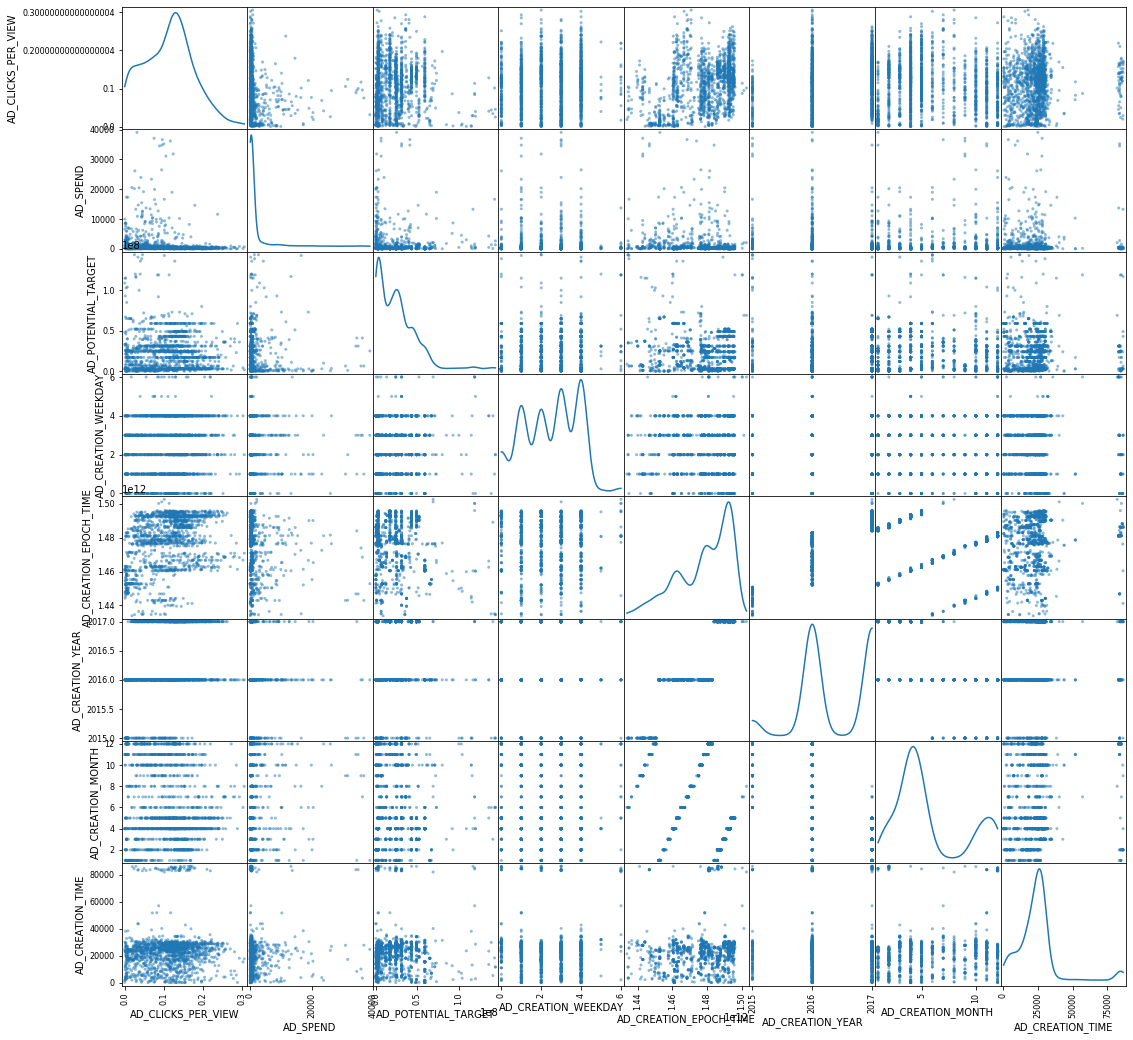

In [16]:
scatter_matrix(corrDf[['AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterALL.png")

In [17]:
corr = corrDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']].corr()
corr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_TIME
AD_CLICKS,1.000000,0.771097,0.287229,0.273346,0.091289,0.262391,0.242846,-0.071775,0.096041
AD_IMPRESSIONS,0.771097,1.000000,-0.055322,0.551563,0.056605,0.092323,0.084237,-0.020477,0.035253
AD_CLICKS_PER_VIEW,0.287229,-0.055322,1.000000,-0.186515,-0.012636,0.354221,0.322339,-0.095626,0.080137
AD_SPEND,0.273346,0.551563,-0.186515,1.000000,-0.047770,-0.184215,-0.182771,0.078756,-0.016608
AD_POTENTIAL_TARGET,0.091289,0.056605,-0.012636,-0.047770,1.000000,-0.161395,-0.090045,-0.079590,-0.041516
AD_CREATION_EPOCH_TIME,0.262391,0.092323,0.354221,-0.184215,-0.161395,1.000000,0.888941,-0.208785,0.136586
AD_CREATION_YEAR,0.242846,0.084237,0.322339,-0.182771,-0.090045,0.888941,1.000000,-0.632334,0.051611
AD_CREATION_MONTH,-0.071775,-0.020477,-0.095626,0.078756,-0.079590,-0.208785,-0.632334,1.000000,0.121738
AD_CREATION_TIME,0.096041,0.035253,0.080137,-0.016608,-0.041516,0.136586,0.051611,0.121738,1.000000


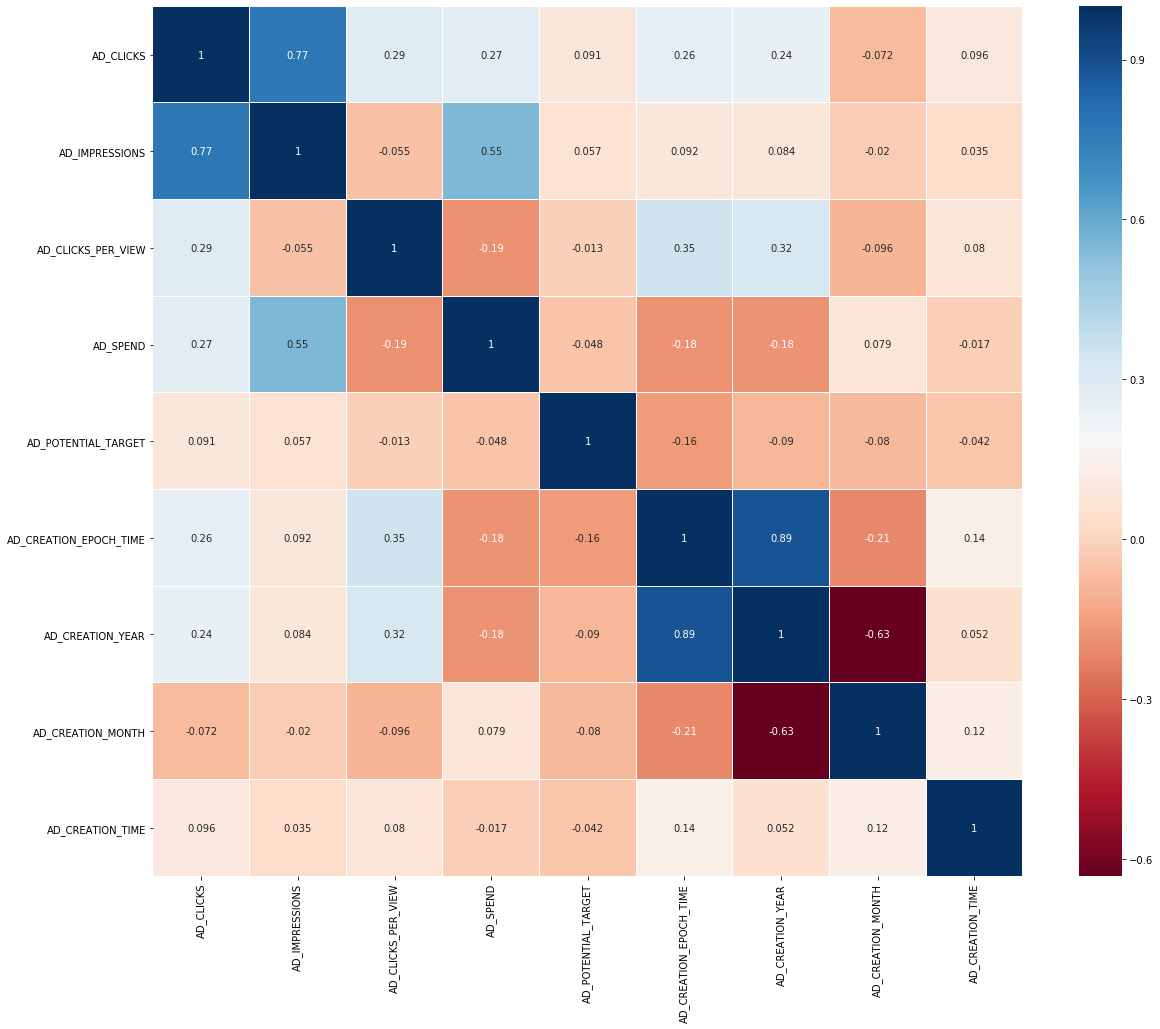

In [18]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(corr,ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"../Images/corrALL.png")

In [19]:
corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.889771,0.498793,0.064635
AD_IMPRESSIONS,0.889771,1.000000,0.150179,0.042541
AD_CLICKS_PER_VIEW,0.498793,0.150179,1.000000,0.076336
AD_CREATION_WEEKDAY,0.064635,0.042541,0.076336,1.000000


### Regression Model
**[TODO]** ==> Julian

In [20]:
X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']]
#X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_MONTH', 'AD_CREATION_YEAR', 'AD_POTENTIAL_TARGET', 'AD_SPEND', 'AD_CREATION_TIME']]
Y= corrDf['AD_CLICKS_PER_VIEW']

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

#### Normal Multiple Linear Regression

In [22]:
reg = LinearRegression()
reg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
y_pred = reg.predict(X_test)

In [24]:
print(reg.coef_)

[ 2.71650853e-03  8.36448301e-12 -2.24509755e-01 -1.91774315e-02
  1.97977694e-07  1.85123338e-11 -1.92447989e-06]


In [25]:
print(reg.intercept_)

440.5510623861301


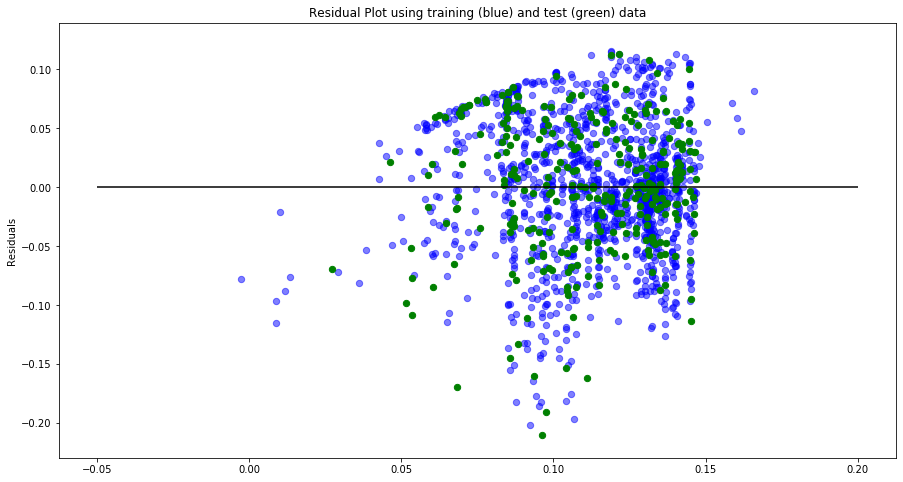

In [26]:
plt.scatter(reg.predict(X_train), reg.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(reg.predict(X_test), reg.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.05, xmax=0.2)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

**Very low R^2 score, so the prediction isn't very good**

In [27]:
r2_score(Y_test, y_pred)

0.15606168886315275

In [28]:
reg.score(X_test,Y_test)

0.15606168886315275

In [29]:
mean_squared_error(Y_test, y_pred)

0.0031560733890617964

#### Multiple Linear Regression (Lasso)

In [30]:
regLasso = Lasso()
regLasso.fit(X_train, Y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
y_pred_lasso = regLasso.predict(X_test)

In [32]:
print(regLasso.coef_)

[ 0.00000000e+00  1.35423820e-12  0.00000000e+00 -0.00000000e+00
  1.56191408e-07  4.43945815e-11 -1.88378646e-06]


In [33]:
print(regLasso.intercept_)

-1.8931169392466198


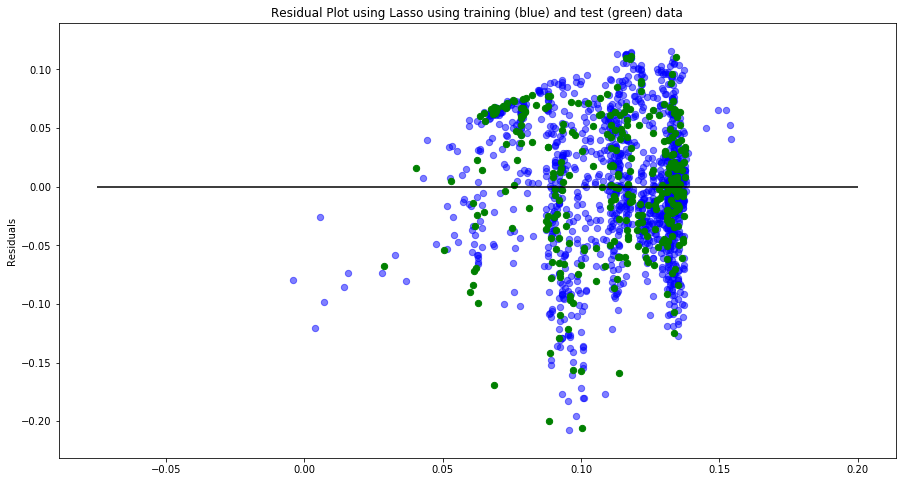

In [34]:
plt.scatter(regLasso.predict(X_train), regLasso.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(regLasso.predict(X_test), regLasso.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.075, xmax=0.2)
plt.title('Residual Plot using Lasso using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

**Also a very low R^2 score, so the prediction isn't very good**

In [35]:
r2_score(Y_test, y_pred_lasso)

0.1471498523616549

In [36]:
regLasso.score(X_test,Y_test)

0.1471498523616549

In [37]:
mean_squared_error(Y_test, y_pred_lasso)

0.003189400955376636

#### Multiple Linear Regression (Elastic Net)

In [38]:
regElastic = ElasticNet(normalize=True)
search=GridSearchCV(estimator=regElastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)

search.fit(X,Y)
param = search.best_params_

In [39]:
regElastic=ElasticNet(normalize=True,alpha=param['alpha'],l1_ratio=param['l1_ratio'])
regElastic.fit(X_train, Y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.4,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
y_pred_elastic = regElastic.predict(X_test)

In [41]:
print(regElastic.coef_)

[ 1.79538869e-03  8.76901928e-13  9.01437835e-03 -0.00000000e+00
  1.05357919e-07  0.00000000e+00 -1.54494228e-06]


In [42]:
print(regElastic.intercept_)

-19.36641908279662


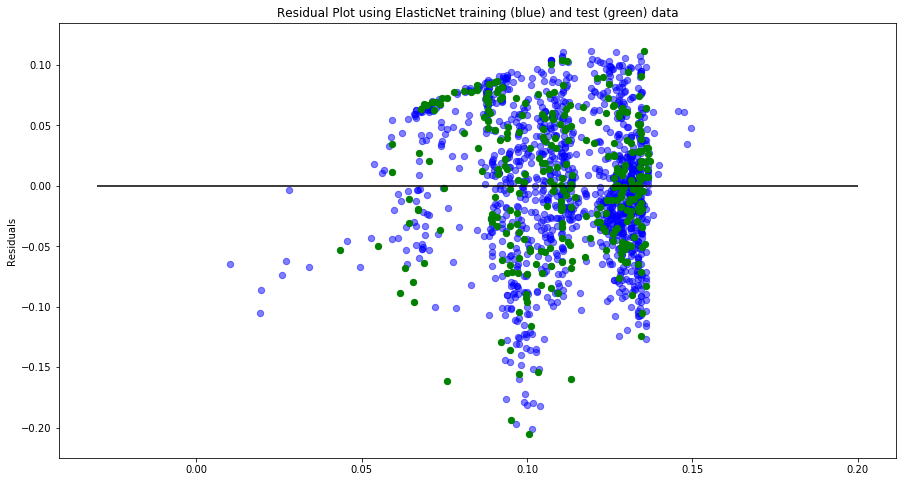

In [43]:
plt.scatter(regElastic.predict(X_train), regElastic.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(regElastic.predict(X_test), regElastic.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residual Plot using ElasticNet training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

In [44]:
r2_score(Y_test, y_pred_elastic)

0.140299464473864

In [45]:
regElastic.score(X_test, Y_test)

0.140299464473864

In [46]:
mean_squared_error(Y_test, y_pred_elastic)

0.00321501932893795

### Polynomial Regression

In [47]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_std)
X_train, X_test, Y_train, Y_test = train_test_split(X_poly,Y, test_size=0.2, random_state=0)

NameError: name 'X_std' is not defined

#### Polynomial Regression

In [ ]:
    pr = LinearRegression()
    pr.fit(X_train, Y_train)
    Y_train_pred = pr.predict(X_train)
    Y_test_pred = pr.predict(X_test)

    print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(Y_train, Y_train_pred),
                    mean_squared_error(Y_test, Y_test_pred))) 

#### Polynomial Regression (Lasso)

In [ ]:
for i in [0.01, 1, 10, 100, 1000]:
    pr_lasso = Lasso(alpha=i, tol=0.01)
    pr_lasso.fit(X_train, Y_train)
    Y_train_pred = pr_lasso.predict(X_train)
    Y_test_pred = pr_lasso.predict(X_test)

    print('\n[Alpha = %d]' % i )
    print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(Y_train, Y_train_pred),
                    mean_squared_error(Y_test, Y_test_pred))) 

In [ ]:
pr_lasso = Lasso(alpha=0.002, tol=0.2)
pr_lasso.fit(X_train, Y_train)
plt.scatter(pr_lasso.predict(X_train), pr_lasso.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(pr_lasso.predict(X_test), pr_lasso.predict(X_test) - Y_test, c='g', s=40)
plt.title('Residual Plot using Lasso using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

------------

In [ ]:
def regression(X, Y):
    for x_el in X:
        X_train, X_test, Y_train, Y_test = train_test_split(x_el,Y, test_size=0.2, random_state=0)

        print('Linear Regression:')
        reg(x_el, X_train, X_test, Y_train, Y_test, LinearRegression())
        
        print('Linear Regression w/ Lasso:')
        reg(x_el, X_train, X_test, Y_train, Y_test, Lasso())
        
        #print('Linear Regression w/ Ridge:')
        #reg(x_el, X_train, X_test, Y_train, Y_test, Ridge())
        
        print('Linear Regression w/ ElasticNet:')    
        regElastic(x_el, X_train, X_test, Y_train, Y_test)
        
        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(x_el)
        X_train, X_test, Y_train, Y_test = train_test_split(X_poly,Y, test_size=0.2, random_state=0)
        
        print('Polynomial Regression:')
        reg(x_el, X_train, X_test, Y_train, Y_test, LinearRegression())
        
        print('Polynomial Regression w/ Lasso:')
        reg(x_el, X_train, X_test, Y_train, Y_test, Lasso())
        
        #print('Polynomial Regression w/ Ridge:')
        #reg(x_el, X_train, X_test, Y_train, Y_test, Ridge()) 
        
        print('Polynomial Regression w/ ElasticNet:')    
        regElastic(x_el, X_train, X_test, Y_train, Y_test)
        

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def reg(x_el, X_train, X_test, Y_train, Y_test, reg):
    reg.fit(X_train, Y_train)
    y_pred = reg.predict(X_test)
    coef = reg.coef_
    intercept = reg.intercept_
    r2 = r2_score(Y_test, y_pred)
    MSA = mean_absolute_error(Y_test, y_pred) 
    MSE = mean_squared_error(Y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(Y_test, y_pred))
    ev = explained_variance_score(Y_test, y_pred)
    
    df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
    df1 = df.head(25)
    
    df1.plot(kind='bar',figsize=(10,8))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    plt.scatter(reg.predict(X_train), reg.predict(X_train) - Y_train, c='b', s=40, alpha=0.5, label='Train Data')
    plt.scatter(reg.predict(X_test), reg.predict(X_test) - Y_test, c='g', s=40, label='Test Data')
    plt.hlines(y=0, xmin=-0.03, xmax=0.2)
    plt.title('Residual Plot of Polynomial Regression using ElasticNet')
    plt.ylabel('Residuals')
    plt.xlabel('Predicted Click-per-View Ratio')
    plt.legend()
    plt.show()
    
    coef_dict_baseline = {}
    for coef, feat in zip(reg.coef_,x_el.columns):
        coef_dict_baseline[feat] = coef
    coef_dict_baseline
    
    print('Intercept: %.2f, R-Squared: %.8f, MSA: %.8f, MSE: %.8f, RMSE: %.8f, EV: %.8f' %(intercept, r2, MSA, MSE, RMSE, ev))
    print(coef_dict_baseline)

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def regElastic(x_el, X_train, X_test, Y_train, Y_test):
    regElastic = ElasticNet(normalize=True)
    search=GridSearchCV(estimator=regElastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)
    
    search.fit(X_train,Y_train)
    param = search.best_params_

    regElastic=ElasticNet(normalize=True,alpha=param['alpha'],l1_ratio=param['l1_ratio'])
    regElastic.fit(X_train, Y_train)
    y_pred_elastic = regElastic.predict(X_test)
    coef_elastic = regElastic.coef_
    intercept_elastic = regElastic.intercept_
    r2_elastic = r2_score(Y_test, y_pred_elastic)
    MSA_elastic = mean_absolute_error(Y_test, y_pred_elastic) 
    MSE_elastic = mean_squared_error(Y_test, y_pred_elastic)
    RMSE_elastic = np.sqrt(mean_squared_error(Y_test, y_pred_elastic))
    ev = explained_variance_score(Y_test, y_pred_elastic)
    
    df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred_elastic})
    df1 = df.head(25)
    
    df1.plot(kind='bar',figsize=(10,8))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    plt.scatter(regElastic.predict(X_train), regElastic.predict(X_train) - Y_train, c='b', s=40, alpha=0.5, label='Train Data')
    plt.scatter(regElastic.predict(X_test), regElastic.predict(X_test) - Y_test, c='g', s=40, label='Test Data')
    plt.hlines(y=0, xmin=-0.03, xmax=0.2)
    plt.title('Residual Plot of Polynomial Regression using ElasticNet')
    plt.ylabel('Residuals')
    plt.xlabel('Predicted Click-per-View Ratio')
    plt.legend()
    plt.show()
    
    coef_dict_elastic = {}
    for coef, feat in zip(regElastic.coef_,x_el.columns):
        coef_dict_elastic[feat] = coef
    coef_dict_elastic
    print('Intercept: %.8f, R-Squared: %.8f, MSA: %.8f, MSE: %.8f, RMSE: %.8f, EV: %.8f' %(intercept_elastic, r2_elastic, MSA_elastic, MSE_elastic, RMSE_elastic, ev))
    print(coef_dict_elastic, '\n')

In [ ]:
X= [corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME']],corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']],corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']], corrDf[['AD_POTENTIAL_TARGET', 'AD_SPEND']]]
#X= [corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']]]
Y= corrDf['AD_CLICKS_PER_VIEW']

In [ ]:
regression(X,Y)